# Business Problem

For airline companies to effectively conduct operational and financial planning, it is imperative to accurately forecast future passenger demand. Predicting future airline passenger demand based on historical data can assist companies in utilizing their resources more efficiently, increasing their revenues, and minimizing costs. This study aims to use time series analysis techniques to predict future passenger numbers, leveraging a dataset that captures monthly total airline passenger counts starting from 1949.

# Dataset Story

* **Dataset Origin:** The dataset captures the monthly total airline passenger counts starting from 1949.
* **Total Observations:** There are 144 monthly observations in the dataset.
* **Average Monthly Passengers:** On average, there are about 280 passengers monthly.
* **Highest Monthly Count:** The highest monthly passenger count observed is 622.
* **Lowest Monthly Count:** The lowest monthly passenger count observed is 104.
* **Importance:** Forecasting passenger counts is essential for airline companies to effectively conduct operational and financial planning.

# Importings

In [1]:
!pip install -q pmdarima

In [2]:
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load Dataset

In [4]:
def load():
    df = pd.read_csv("/kaggle/input/airline-passangers/airline-passengers.csv", index_col="month", parse_dates=True)

    return df

df = load()

df.head(10)

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [5]:
df.tail(10)

,total_passengers
month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


# Overview & Time Series Structural Analysis

## Overview

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of Unique Values #####################")
    print(df.nunique())

In [7]:
check_df(df)

##################### Shape #####################
(144, 1)
##################### Types #####################
total_passengers    int64
dtype: object
##################### Duplicated Values #####################
26
##################### Missing Values #####################
total_passengers    0
dtype: int64
##################### Number of Unique Values #####################
total_passengers    118
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   total_passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


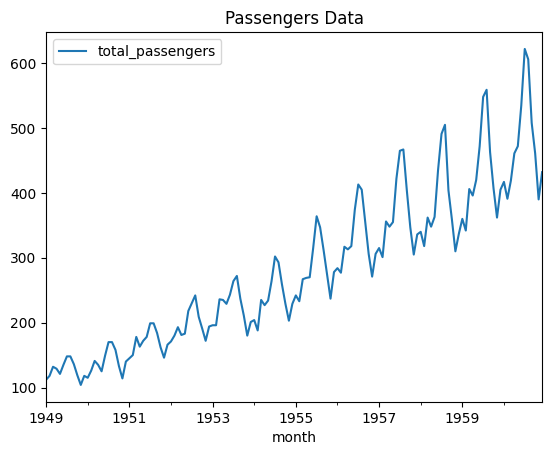

In [9]:
df[["total_passengers"]].plot(title="Passengers Data")
plt.show()

In [10]:
df.index.freq = "MS"

## Train-Test Split

In [11]:
train = df[:120]
test = df[120:]

## Structural Analysis

In [12]:
def is_stationary(y):
    # "HO: Non-Stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        result = f"Stationary (H1: Stationary, p-value: {round(p_value, 3)})"
    else:
        result = f"Non-Stationary (H0: Non-Stationary, p-value: {round(p_value, 3)})"
    return result

In [13]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, "k", label="Original " + model)
    axes[0].legend(loc="upper left")

    axes[1].plot(result.trend, label="Trend")
    axes[1].legend(loc="upper left")

    axes[2].plot(result.seasonal, "g", label="Seasonality & Mean: " + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc="upper left")

    axes[3].plot(result.resid, "r", label="Residuals & Mean: " + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc="upper left")

    if stationary:
        stationarity_result = is_stationary(y)
        axes[1].text(0.95, 0.05, stationarity_result,
                     verticalalignment="bottom", horizontalalignment="right",
                     transform=axes[1].transAxes,
                     color="blue", fontsize=12, bbox=dict(facecolor="white", alpha=0.5))

    plt.show(block=True)

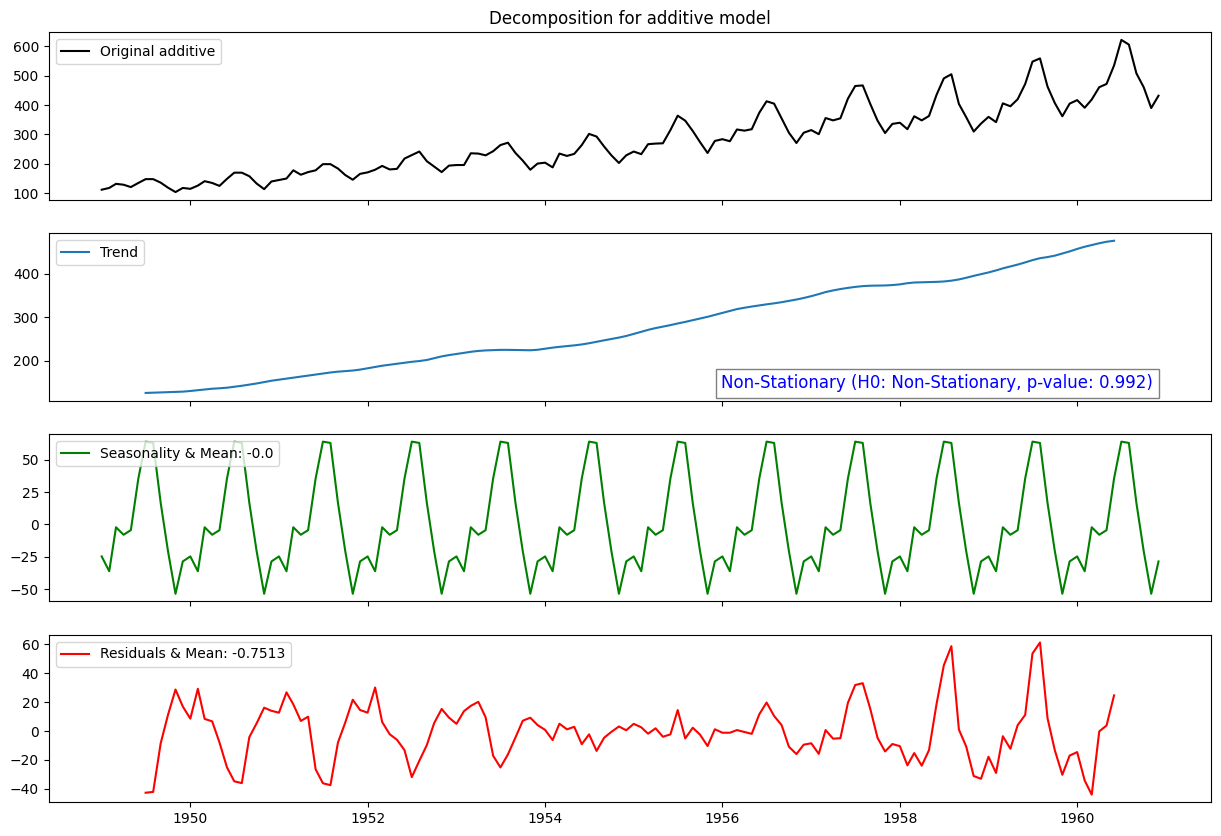

In [14]:
ts_decompose(df, stationary=True)

## Prediction Plot Func

In [15]:
def plot_prediction(train, test, y_pred, conf, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    if conf is not None:
        plt.fill_between(test.index, conf[:,0], conf[:,1], color="gray", label="CONF")
    plt.show()

# SES - Single Exponential Smoothing

In [16]:
# SES Optimizer
def ses_optimizer(train, test, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

In [17]:
alphas = np.arange(0.01, 1, 0.10)

best_alpha, best_mae = ses_optimizer(train, test, alphas, step=24)

alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


In [18]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

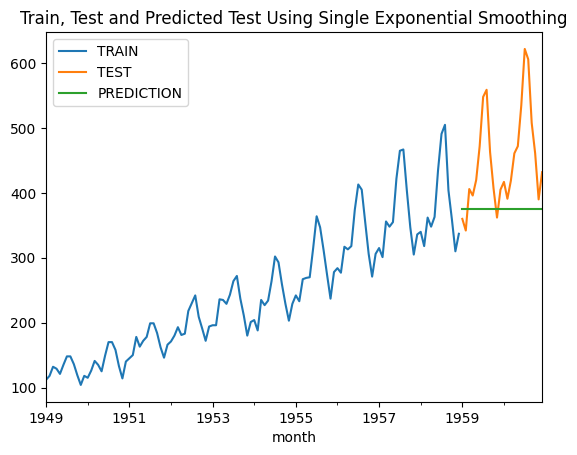

In [19]:
plot_prediction(train, test, y_pred, conf=None, label="Single Exponential Smoothing")

# DES - Double Exponential Smoothing

In [20]:
# DES Optimizer
def des_optimizer(train, test, alphas, betas, step=48):
    best_alpha, best_beta, best_mae, best_trend = None, None, float("inf"), None
    trends = ["add", "mul"]
    
    for trend in trends:
        for alpha in alphas:
            for beta in betas:
                des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
                y_pred = des_model.forecast(step)
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_alpha, best_beta, best_mae, best_trend = alpha, beta, mae, trend
                print(f"trend: {trend}, alpha: {alpha:.2f}, beta: {beta:.2f}, mae: {mae:.4f}")
    
    print(f"Best parameters: alpha: {best_alpha:.2f}, beta: {best_beta:.2f}, mae: {best_mae:.4f}, trend: {best_trend}")
    return best_alpha, best_beta, best_mae, best_trend

In [21]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae, best_trend = des_optimizer(train, test, alphas, betas, step=24)

trend: add, alpha: 0.01, beta: 0.01, mae: 54.9512
trend: add, alpha: 0.01, beta: 0.11, mae: 54.1036
trend: add, alpha: 0.01, beta: 0.21, mae: 55.5568
trend: add, alpha: 0.01, beta: 0.31, mae: 57.3247
trend: add, alpha: 0.01, beta: 0.41, mae: 57.7931
trend: add, alpha: 0.01, beta: 0.51, mae: 57.9968
trend: add, alpha: 0.01, beta: 0.61, mae: 57.9637
trend: add, alpha: 0.01, beta: 0.71, mae: 57.5635
trend: add, alpha: 0.01, beta: 0.81, mae: 57.3334
trend: add, alpha: 0.01, beta: 0.91, mae: 57.8983
trend: add, alpha: 0.11, beta: 0.01, mae: 55.0309
trend: add, alpha: 0.11, beta: 0.11, mae: 58.4728
trend: add, alpha: 0.11, beta: 0.21, mae: 69.6339
trend: add, alpha: 0.11, beta: 0.31, mae: 72.5550
trend: add, alpha: 0.11, beta: 0.41, mae: 78.8168
trend: add, alpha: 0.11, beta: 0.51, mae: 81.9960
trend: add, alpha: 0.11, beta: 0.61, mae: 77.2262
trend: add, alpha: 0.11, beta: 0.71, mae: 71.5042
trend: add, alpha: 0.11, beta: 0.81, mae: 69.0258
trend: add, alpha: 0.11, beta: 0.91, mae: 67.8408


In [22]:
des_model = ExponentialSmoothing(train, trend=best_trend).fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(24)

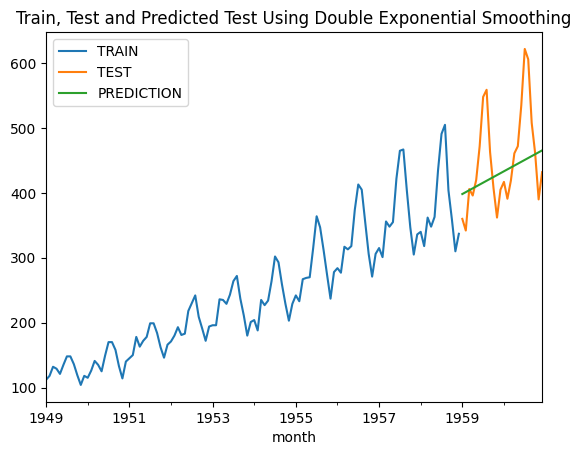

In [23]:
plot_prediction(train, test, y_pred, conf=None, label="Double Exponential Smoothing")

# TES - Triple Exponential Smoothing

In [24]:
# TES Optimizer
def tes_optimizer(train, test, alphas, betas, gammas, seasonal_periods, step=48):
    best_params = {
        "alpha": None, "beta": None, "gamma": None, 
        "mae": float("inf"), "trend": None, "seasonal": None
    }
    seasonals = ["add", "mul"]
    trends = ["add", "mul", None]
    
    # NaN değerleri kontrol et ve temizle
    train = train.dropna()
    test = test.dropna()
    
    if len(train) == 0 or len(test) == 0:
        raise ValueError("Veri setleri NaN değerler temizlendikten sonra boş!")

    # Çarpımsal mevsimsellik için veri setini kontrol et
    if np.any(train <= 0):
        print("Uyarı: Veri setinde sıfır veya negatif değerler var. Sadece toplamsal mevsimsellik kullanılacak.")
        seasonals = ["add"]
    
    for seasonal in seasonals:
        for trend in trends:    
            for alpha in alphas:    
                for beta in betas:
                    for gamma in gammas:
                        try:
                            tes_model = ExponentialSmoothing(
                                train, 
                                trend=trend, 
                                seasonal=seasonal, 
                                seasonal_periods=seasonal_periods
                            ).fit(
                                smoothing_level=alpha, 
                                smoothing_trend=beta, 
                                smoothing_seasonal=gamma
                            )
                            
                            y_pred = tes_model.forecast(step)
                            
                            # Tahmin ve test verilerinin uzunluklarını eşitle
                            min_len = min(len(y_pred), len(test))
                            y_pred = y_pred[:min_len]
                            test_trunc = test[:min_len]
                            
                            mae = mean_absolute_error(test_trunc, y_pred)
                            
                            if mae < best_params["mae"]:
                                best_params.update({
                                    "alpha": alpha, "beta": beta, "gamma": gamma,
                                    "mae": mae, "trend": trend, "seasonal": seasonal
                                })
                            
                            print(f"seasonal: {seasonal}, trend: {trend}, "
                                  f"alpha: {alpha:.2f}, beta: {beta:.2f}, "
                                  f"gamma: {gamma:.2f}, mae: {mae:.4f}")
                        
                        except Exception as e:
                            print(f"Hata oluştu: {e}")
                            continue

    print(f"En iyi parametreler: alpha: {best_params['alpha']:.2f}, beta: {best_params['beta']:.2f}, gamma: {best_params['gamma']:.2f}, mae: {best_params['mae']:.4f}, trend: {best_params['trend']}, seasonal: {best_params['seasonal']}")

    return (best_params["alpha"], best_params["beta"], best_params["gamma"],
            best_params["mae"], best_params["trend"], best_params["seasonal"])

In [25]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)

best_alpha, best_beta, best_gamma, best_mae, best_trend, best_seasonal = tes_optimizer(train, test, alphas, betas, gammas, seasonal_periods=12, step=24)

seasonal: add, trend: add, alpha: 0.10, beta: 0.10, gamma: 0.10, mae: 36.8284
seasonal: add, trend: add, alpha: 0.10, beta: 0.10, gamma: 0.30, mae: 34.8767
seasonal: add, trend: add, alpha: 0.10, beta: 0.10, gamma: 0.50, mae: 35.9100
seasonal: add, trend: add, alpha: 0.10, beta: 0.10, gamma: 0.70, mae: 38.7169
seasonal: add, trend: add, alpha: 0.10, beta: 0.10, gamma: 0.90, mae: 42.5466
seasonal: add, trend: add, alpha: 0.10, beta: 0.30, gamma: 0.10, mae: 53.9568
seasonal: add, trend: add, alpha: 0.10, beta: 0.30, gamma: 0.30, mae: 52.9994
seasonal: add, trend: add, alpha: 0.10, beta: 0.30, gamma: 0.50, mae: 56.9753
seasonal: add, trend: add, alpha: 0.10, beta: 0.30, gamma: 0.70, mae: 61.3755
seasonal: add, trend: add, alpha: 0.10, beta: 0.30, gamma: 0.90, mae: 67.1721
seasonal: add, trend: add, alpha: 0.10, beta: 0.50, gamma: 0.10, mae: 56.7649
seasonal: add, trend: add, alpha: 0.10, beta: 0.50, gamma: 0.30, mae: 51.7216
seasonal: add, trend: add, alpha: 0.10, beta: 0.50, gamma: 0.50,

In [26]:
tes_model = ExponentialSmoothing(train, trend=best_trend, seasonal=best_seasonal, seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(24)

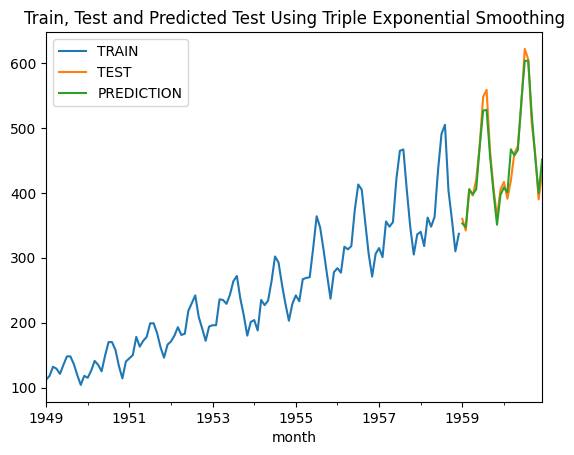

In [27]:
plot_prediction(train, test, y_pred, conf=None, label="Triple Exponential Smoothing")

# ARIMA(p, d, q): Autoregressive Integrated Moving Average

## Auto ARIMA

In [28]:
arima_model = auto_arima(train, trace=True, seasonal=False)

y_pred, conf = arima_model.predict(24, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1087.029, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1140.292, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1132.336, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.668, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1138.809, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1126.948, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.189 seco

In [29]:
mean_absolute_error(test, y_pred)

46.92745392785028

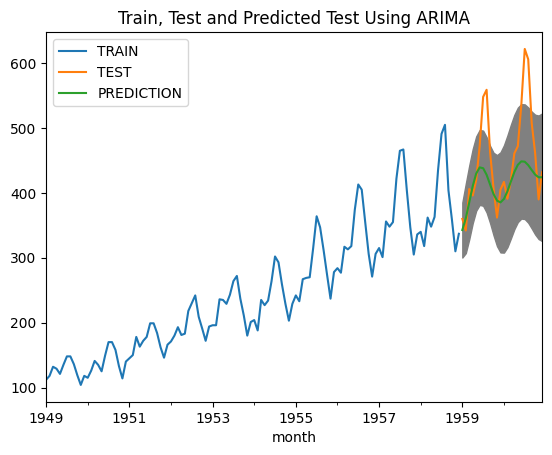

In [30]:
plot_prediction(train, test, y_pred, conf=conf, label="ARIMA")

# SARIMA(p, d, q) (P, D, Q) m: Seasonal Autoregressive Integrated Moving Average

## AIC Optimizer

In [31]:
# SARIMA Optimizer AIC
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:  # noqa: E722
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.6320531158312
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883429307
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.0696747520262
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865853758386
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.301097909056
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611883
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6074014199974
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1524.3620853403545
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1403.5942348893623
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:967.5225695583002
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:942.2425093046857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1136.4998829458498
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1127.839703073852
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.2233876021429
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.7294811853319
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.8088994229304
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1

In [33]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=24)

In [34]:
y_pred = y_pred_test.predicted_mean

mean_absolute_error(test, y_pred)

68.57726547031133

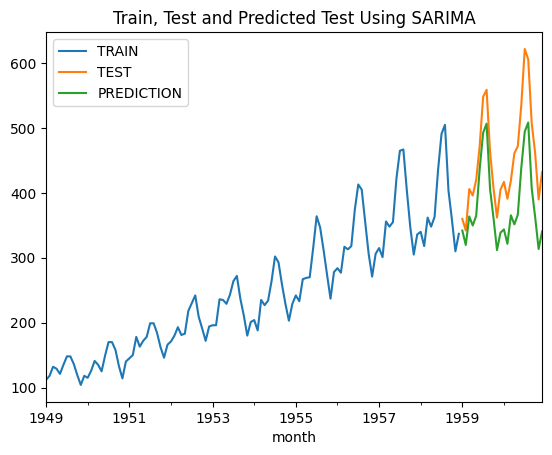

In [35]:
plot_prediction(train, test, y_pred, conf=None, label="SARIMA")

## Auto SARIMA

In [36]:
sarima_model = auto_arima(train, trace=True, seasonal=True, m=12)

y_pred, conf = sarima_model.predict(24, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.750, Time=3.03 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.11 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=1.58 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.16 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.92 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.58 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.37 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.22 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

In [37]:
mean_absolute_error(test, y_pred)

43.46489436165564

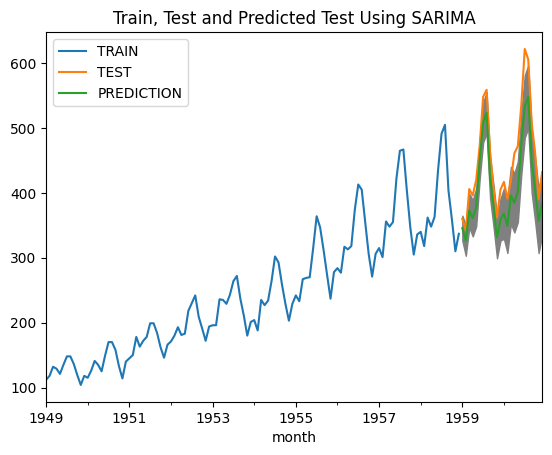

In [38]:
plot_prediction(train, test, y_pred, conf=conf, label="SARIMA")

## MAE Optimizer

In [39]:
# SARIMA Optimizer MAE
def sarima_optimizer_mae(train, test, pdq, seasonal_pdq, steps):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=steps)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:  # noqa: E722
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))

    return best_order, best_seasonal_order

In [40]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, test, pdq, seasonal_pdq, 24)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.2095457532533
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.62972633845074
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93604914677968
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79705573389303
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.59973872393609
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.626157879495242
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260292
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.28978563277764
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.49252847732824
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051675444973
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.48449855430056
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43309216830473
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.0138854544197
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.733828397078714
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368436557336
SARIMA(0, 1, 0)x(0, 1, 

In [41]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=24)

In [42]:
y_pred = y_pred_test.predicted_mean

mean_absolute_error(test, y_pred)

30.626157879495242

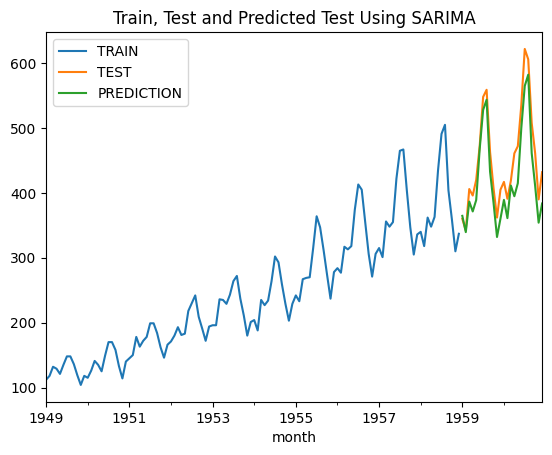

In [43]:
plot_prediction(train, test, y_pred, conf=None, label="SARIMA")

# Final Model

In [44]:
# BEST MODEL = TES

In [45]:
# best_alpha: 0.1 best_beta: 0.9 best_gamma: 0.1 best_mae: 10.9649, best_trend: add, best_seasonal: mul

In [46]:
tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=0.1, smoothing_slope=0.9, smoothing_seasonal=0.1)

In [47]:
tes_model_final.forecast(6)

1961-01-01   452.967
1961-02-01   439.485
1961-03-01   507.063
1961-04-01   506.782
1961-05-01   519.795
1961-06-01   597.402
Freq: MS, dtype: float64